In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pathlib

# Predição de mortalidade infantil baseado no dataset TWINS

O dataset original pode ser encontrado em ../data/original. Ele foi tratado no notebook de número 1 nessa mesma pasta, produzindo o dataset tratado em ../data/treated/. Além disso, foram feitas visualizações e computadas estatísticas no notebook de número 2.

In [2]:
data_path = pathlib.Path("../data/treated/twins_data.csv")
data_df = pd.read_csv(data_path)

Sumário:

- Tratamento dos dados para o treino
    - Lidando com dados faltando
- Treinando os modelos
    - Dividindo os dados em treino e teste
    - Normalizando a coluna não categórica
    - Aplicando os modelos
        - Treinando os modelos
    - Análise dos resultados
        - Sobre os dados de teste
- Retreinando sobre dados melhor balanceados
    - Aplicando os modelos novamente
    - Nova análise dos resultados

## Tratamento dos dados para treino

In [3]:
data_df.head()

,pldel,birattnd,brstate,stoccfipb,mager8,ormoth,mrace,meduc6,dmar,mplbir,...,dlivord_min,dtotord_min,brstate_reg,stoccfipb_reg,mplbir_reg,lighter,first,id,weight,died
0,1.0,1.0,1.0,1.0,3.0,0.0,1.0,NaN,1.0,31.0,...,NaN,NaN,5.0,5.0,1.0,1.0,NaN,1.0,2268.0,0.0
1,1.0,1.0,1.0,1.0,3.0,0.0,1.0,NaN,1.0,31.0,...,NaN,NaN,5.0,5.0,1.0,0.0,NaN,0.0,2296.0,0.0
2,1.0,1.0,1.0,1.0,3.0,0.0,2.0,3.0,0.0,1.0,...,2.0,3.0,5.0,5.0,5.0,1.0,0.0,7.0,2610.0,0.0
3,1.0,1.0,1.0,1.0,3.0,0.0,2.0,3.0,0.0,1.0,...,2.0,3.0,5.0,5.0,5.0,0.0,1.0,6.0,2650.0,0.0
4,1.0,1.0,1.0,1.0,5.0,0.0,1.0,5.0,1.0,59.0,...,NaN,NaN,5.0,5.0,1.0,1.0,NaN,11.0,1985.0,0.0


Não precisamos da coluna 'id'.

In [4]:
data_df.drop('id', inplace=True, axis=1)

In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142690 entries, 0 to 142689
Data columns (total 52 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   pldel          142642 non-null  float64
 1   birattnd       142462 non-null  float64
 2   brstate        142690 non-null  float64
 3   stoccfipb      142690 non-null  float64
 4   mager8         142690 non-null  float64
 5   ormoth         138638 non-null  float64
 6   mrace          142690 non-null  float64
 7   meduc6         134012 non-null  float64
 8   dmar           142690 non-null  float64
 9   mplbir         142474 non-null  float64
 10  mpre5          139436 non-null  float64
 11  adequacy       136352 non-null  float64
 12  orfath         119046 non-null  float64
 13  frace          122170 non-null  float64
 14  birmon         142690 non-null  float64
 15  gestat10       142690 non-null  float64
 16  csex           142690 non-null  float64
 17  anemia         134210 non-nul

Todas as colunas estão marcadas como float64, entretanto, a grande maioria é categórica. Alterar o seu tipo para 'category' deve diminuir o consumo de memória de 56.6MB. Vamos ver quantos valores diferentes cada coluna tem:

In [6]:
values_per_col = dict()
for col in data_df.columns:
    values_per_col[col] = len(data_df[col].value_counts())

In [7]:
values_per_col

{'pldel': 5,
 'birattnd': 5,
 'brstate': 55,
 'stoccfipb': 51,
 'mager8': 8,
 'ormoth': 6,
 'mrace': 9,
 'meduc6': 5,
 'dmar': 2,
 'mplbir': 58,
 'mpre5': 4,
 'adequacy': 3,
 'orfath': 6,
 'frace': 9,
 'birmon': 12,
 'gestat10': 10,
 'csex': 2,
 'anemia': 2,
 'cardiac': 2,
 'lung': 2,
 'diabetes': 2,
 'herpes': 2,
 'hydra': 2,
 'hemo': 2,
 'chyper': 2,
 'phyper': 2,
 'eclamp': 2,
 'incervix': 2,
 'pre4000': 2,
 'preterm': 2,
 'renal': 2,
 'rh': 2,
 'uterine': 2,
 'othermr': 2,
 'tobacco': 2,
 'alcohol': 2,
 'cigar6': 6,
 'drink5': 5,
 'crace': 9,
 'data_year': 3,
 'nprevistq': 5,
 'dfageq': 8,
 'feduc6': 5,
 'dlivord_min': 16,
 'dtotord_min': 20,
 'brstate_reg': 9,
 'stoccfipb_reg': 9,
 'mplbir_reg': 9,
 'lighter': 2,
 'first': 2,
 'weight': 3236,
 'died': 2}

Algumas colunas são claramente categóricas. Vamos ver o que significa algumas dessas colunas.

In [8]:
cols_sig = {'adequacy': 'adequacy of care',
 'alcohol': 'risk factor, alcohol use',
 'anemia': 'risk factor, Anemia',
 'birattnd': 'medical person attending birth',
 'birmon': 'birth month Jan-Dec',
 'bord_0': 'birth order of lighter twin',
 'bord_1': 'birth order of heavier twin',
 'brstate': 'state of residence NCHS',
 'brstate_reg': 'US census region of brstate',
 'cardiac': 'risk factor, Cardiac',
 'chyper': 'risk factor, Hypertension, chronic',
 'cigar6': 'num of cigarettes /day, quantiled',
 'crace': 'race of child',
 'csex': 'sex of child',
 'data_year': 'year: 1989, 1990 or 1991',
 'dfageq': 'octile age of father',
 'diabetes': 'risk factor, Diabetes',
 'dlivord_min': 'number of live births before twins',
 'dmar': 'married',
 'drink5': 'num of drinks /week, quantiled',
 'dtotord_min': 'total number of births before twins',
 'eclamp': 'risk factor, Eclampsia',
 'feduc6': 'education category',
 'frace': 'dad race',
 'gestat10': 'gestation 10 categories',
 'hemo': 'risk factor Hemoglobinopathy',
 'herpes': 'risk factor, Herpes',
 'hydra': 'risk factor Hvdramnios/Oliqohvdramnios',
 'incervix': 'risk factor, Incompetent cervix',
 'infant_id_0': 'infant id of lighter twin in original df',
 'infant_id_1': 'infant id of heavier twin in original df',
 'lung': 'risk factor, Lung',
 'mager8': 'mom age',
 'meduc6': 'mom education',
 'mplbir': 'mom place of birth',
 'mplbir_reg': 'US census region of mplbir',
 'mpre5': 'trimester prenatal care begun, 4 is none',
 'mrace': 'mom race',
 'nprevistq': 'quintile number of prenatal visits',
 'orfath': 'dad hispanic',
 'ormoth': 'mom hispanic',
 'othermr': 'risk factor, Other Medical Risk Factors',
 'phyper': 'risk factor, Hypertension, preqnancy-associated',
 'pldel': 'place of delivery',
 'pre4000': 'risk factor, Previous infant 4000+ grams',
 'preterm': 'risk factor, Previos pre-term or small',
 'renal': 'risk factor, Renal disease',
 'rh': 'risk factor, RH sensitization',
 'stoccfipb': 'state of occurence FIPB',
 'stoccfipb_reg': 'US census region of stoccfipb',
 'tobacco': 'risk factor, tobacco use',
 'uterine': 'risk factor, Uterine bleeding'}

In [9]:
target_cols = [col for col, value in list(values_per_col.items()) if value > 6]
for col in target_cols:
    desc = cols_sig.get(col, '')
    print(f"{col}: {desc}")

brstate: state of residence NCHS
stoccfipb: state of occurence FIPB
mager8: mom age
mrace: mom race
mplbir: mom place of birth
frace: dad race
birmon: birth month Jan-Dec
gestat10: gestation 10 categories
crace: race of child
dfageq: octile age of father
dlivord_min: number of live births before twins
dtotord_min: total number of births before twins
brstate_reg: US census region of brstate
stoccfipb_reg: US census region of stoccfipb
mplbir_reg: US census region of mplbir
weight: 


Fica claro que o weight não é categórico. Poderia considerar a idade da mãe como não categórico, entretanto, vou dizer que é. 

In [10]:
def transform_to_categorical(df, cols):
    df = df.copy()
    for col in cols:
        df[col] = df[col].astype('category')
    
    return df

NON_CAT_COL = ['weight']
CAT_COLS = data_df.columns.difference(NON_CAT_COL)
data_df = transform_to_categorical(data_df, CAT_COLS)

In [11]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142690 entries, 0 to 142689
Data columns (total 52 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   pldel          142642 non-null  category
 1   birattnd       142462 non-null  category
 2   brstate        142690 non-null  category
 3   stoccfipb      142690 non-null  category
 4   mager8         142690 non-null  category
 5   ormoth         138638 non-null  category
 6   mrace          142690 non-null  category
 7   meduc6         134012 non-null  category
 8   dmar           142690 non-null  category
 9   mplbir         142474 non-null  category
 10  mpre5          139436 non-null  category
 11  adequacy       136352 non-null  category
 12  orfath         119046 non-null  category
 13  frace          122170 non-null  category
 14  birmon         142690 non-null  category
 15  gestat10       142690 non-null  category
 16  csex           142690 non-null  category
 17  anemia    

Agora ele só ocupa 8 MB.

### Lidando com dados faltando

Vamos ver quais são as colunas com dados faltando

In [12]:
data_df.isna().sum()

pldel               48
birattnd           228
brstate              0
stoccfipb            0
mager8               0
ormoth            4052
mrace                0
meduc6            8678
dmar                 0
mplbir             216
mpre5             3254
adequacy          6338
orfath           23644
frace            20520
birmon               0
gestat10             0
csex                 0
anemia            8480
cardiac           8480
lung              8480
diabetes          8480
herpes           21132
hydra            14172
hemo             14172
chyper            8480
phyper            8480
eclamp            8480
incervix         14172
pre4000          14172
preterm          14172
renal             8480
rh               10030
uterine          15440
othermr           8480
tobacco          38508
alcohol          35846
cigar6           39432
drink5           36638
crace                0
data_year            0
nprevistq         4700
dfageq           22234
feduc6           29358
dlivord_min

Antes de retirar os nulos:

In [13]:
data_df['died'].value_counts()

0.0    137566
1.0      5124
Name: died, dtype: int64

In [14]:
5124/len(data_df)

0.03591001471721915

Cerca de 3.5% dos dados representam os que morreram.

Vamos ver quantas entradas sobram se eu remover todas as linhas com um valor faltando

In [15]:
data_without_missing_df = data_df.dropna()
len(data_without_missing_df)

64240

In [16]:
data_without_missing_df['died'].value_counts()

0.0    62368
1.0     1872
Name: died, dtype: int64

In [17]:
1872/64240

0.029140722291407222

A proporção de dados dos que representam morte caiu para 2.9%. Vamos ver se conseguimos melhorar esse número.

In [18]:
na_count = data_df.isna().sum()
cols_with_nas = na_count.loc[na_count>0]
cols_with_nas.sort_values(ascending=True, inplace=True)
for col in cols_with_nas.index.to_list():
    desc = cols_sig.get(col, '')
    print(f"{col}: {desc}; {cols_with_nas[col]}")

pldel: place of delivery; 48
mplbir: mom place of birth; 216
mplbir_reg: US census region of mplbir; 216
birattnd: medical person attending birth; 228
mpre5: trimester prenatal care begun, 4 is none; 3254
ormoth: mom hispanic; 4052
nprevistq: quintile number of prenatal visits; 4700
adequacy: adequacy of care; 6338
othermr: risk factor, Other Medical Risk Factors; 8480
renal: risk factor, Renal disease; 8480
phyper: risk factor, Hypertension, preqnancy-associated; 8480
chyper: risk factor, Hypertension, chronic; 8480
eclamp: risk factor, Eclampsia; 8480
lung: risk factor, Lung; 8480
cardiac: risk factor, Cardiac; 8480
anemia: risk factor, Anemia; 8480
diabetes: risk factor, Diabetes; 8480
meduc6: mom education; 8678
rh: risk factor, RH sensitization; 10030
hydra: risk factor Hvdramnios/Oliqohvdramnios; 14172
hemo: risk factor Hemoglobinopathy; 14172
incervix: risk factor, Incompetent cervix; 14172
pre4000: risk factor, Previous infant 4000+ grams; 14172
preterm: risk factor, Previos pr

Como todas essas feateures são categóricas, não posso usar mediana ou média para completar os dados, teria que ser ou 'o mais comum' ou alguma atribuição aleatória que siga uma distribuição relativa aos dados presentes.

Como existem cerca de 143 mil entradas, vou remover as colunas que possuem mais de 20 mil dados faltantes e completar as outras seguindo a lógica do "mais comum".

Além disso, como são 37 colunas com dados faltando mas apenas 9 com mais de 20 mil dados faltando, vou remover todas as linhas que possuírem, de antemão, mais do que 5 colunas com dados faltando.

In [19]:
data_df.dropna(thresh=len(data_df.columns)-5, inplace=True)

In [20]:
len(data_df)

119794

In [21]:
removed_cols = ['frace', 'herpes', 'dfageq', 'orfath', 'feduc6', 'alcohol', 'drink5', 'tobacco', 'cigar6']
data_df.drop(removed_cols, axis=1, inplace=True)

In [22]:
missing_count = data_df.isna().sum()
missing_cols_names = missing_count.loc[missing_count > 0].index.to_list()
most_common_per_col = dict()
for col in missing_cols_names:
    most_common_per_col[col] = data_df[col].value_counts().idxmax()

In [23]:
most_common_per_col

{'pldel': 1.0,
 'birattnd': 1.0,
 'ormoth': 0.0,
 'meduc6': 3.0,
 'mplbir': 5.0,
 'mpre5': 1.0,
 'adequacy': 1.0,
 'rh': 0.0,
 'uterine': 0.0,
 'nprevistq': 1.0,
 'dlivord_min': 1.0,
 'dtotord_min': 1.0,
 'mplbir_reg': 2.0,
 'first': 0.0}

In [24]:
data_df.fillna(most_common_per_col, inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_17636\476006492.py:1: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_df.fillna(most_common_per_col, inplace=True)


In [25]:
data_df['died'].value_counts()

0.0    115800
1.0      3994
Name: died, dtype: int64

In [26]:
3994/119794

0.03334056797502379

# Treinando os modelos

## Dividindo os dados em treino e teste

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
y = data_df['died']
X = data_df.drop('died', axis=1)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Normalizando a coluna não categórica

In [31]:
from sklearn.preprocessing import MinMaxScaler

In [32]:
def normalize(df, cols, scaler, already_fitted_scaler):
    numerical_only_data = df[cols]
    if not already_fitted_scaler:
        scaler.fit(numerical_only_data.values)
    
    numerical_scaled = scaler.transform(numerical_only_data.values)
    df.loc[:, cols] = numerical_scaled
    return df

Vou realizar o fit do Scaler com base nos dados de treino e aplica-lo também aos dados de teste.

In [33]:
scaler = MinMaxScaler()
NUM_COL = ['weight']
already_fitted_scaler = False
X_train = normalize(X_train, NUM_COL, scaler, already_fitted_scaler)

already_fitted_scaler = True
X_test = normalize(X_test, NUM_COL, scaler, already_fitted_scaler)

In [34]:
X_train['weight'].describe()

count    89845.000000
mean         0.332855
std          0.098904
min          0.000000
25%          0.280219
50%          0.344838
75%          0.399574
max          1.000000
Name: weight, dtype: float64

In [35]:
X_test['weight'].describe()

count    29949.000000
mean         0.332982
std          0.098308
min          0.000608
25%          0.280219
50%          0.344838
75%          0.399574
max          0.745021
Name: weight, dtype: float64

## Aplicando os modelos

Para realizar o treinamento, foram escolhidos os seguintes modelos:

- KNN
- HistGradientBoostingClassifier
- Rede Neural
- DecisionTrees

### Treinando os modelos

In [36]:
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [37]:
CATEGORICAL_COLS_MASK = [True]*41 + [False]

In [38]:
DEFAULT_RANDOM_STATE = 42
#https://stackoverflow.com/a/61183983/16264901
knn_clf = KNeighborsClassifier(n_jobs=-1, algorithm='ball_tree')
hist_clf = HistGradientBoostingClassifier(random_state=DEFAULT_RANDOM_STATE, l2_regularization=1,
                                        categorical_features=CATEGORICAL_COLS_MASK)
neural_clf = MLPClassifier(solver='adam', random_state=DEFAULT_RANDOM_STATE)
forest_clf = RandomForestClassifier(n_jobs=-1, random_state=DEFAULT_RANDOM_STATE)

- Modelo KNN: Apesar de considerar a dimensionalidade como razoavelmente alta, gostaria de ver se um modelo de agrupamento simples conseguiria performar bem. Para tal, de acordo com a documentação o algoritmo 'ball-tree' deve performar melhor em quantidade de computações quando a dimensionalidade do dado é maior do que 20 comparado ao K-DTree.

- Modelo HistGradientBoostingClassifier: De acordo com a documentação, o sklearn possui essa nova implementação de gradient boosting trees para classificação. Esse modelo é inspirado no LightGBM e usa histogramas para dividir os dados. Além disso, na documentação é dito que ele poderia ser ordens de magnitude melhor do que o GradientBoosting caso a quantidade de dados seja maior do que dezenas de milhares, que é o caso atual.

- Modelo Neural: Defini o solver do modelo neural como 'adam', uma variação de stochastic gradient-based optimizer, pois, na documentação, está descrito como funcionar relativamente bem em datasets razoáveis, que, no caso, é de 119k entradas.

- Modelo RandomForest: O modeo RandomForest não possui nada fixo, os seus principais parâmetros serão variados no GridSearchCV

In [39]:
ensemble_clf=[knn_clf, hist_clf, neural_clf, forest_clf]

Vamos realizar um GridSearch com validação cruzada de 5 folds.

In [40]:
len(X_train.columns)

42

In [41]:
hist_params={"learning_rate":[0.001,0.01,0.1], "max_iter":range(100,1000,200), 'max_depth':range(1, 20, 4)}
knn_params = {"n_neighbors": [5, 9, 13, 18], "metric":['euclidean']}
neural_params = {"hidden_layer_sizes":[(42), (42, 20), (42, 20, 10), (42, 20, 10, 5)], "max_iter":[25000]}
forest_params = {'n_estimators':[30, 50, 70, 100], 'min_samples_split':[2, 4, 8, 16], 'criterion':['entropy']}

- HistGradientBoostingClassifier: Por ser um modelo de boosting, os decision stumps do modelo podem/devem ser de baixíssima capacidade. Por padrão, o sklearn não define a profundidade máxima das árvores, portanto, variei esse valor entre 1 e 20. Além disso, variei a quantidade máxima de decision stumps até 1000 pois os modelos de boosting são bem robustos. Também variei o learning_rate.

- KNN: As principais questões do modelo KNN é como computar a distância dos pontos e a quantidade de vizinhos a serem levados em consideração. Dessa forma, defini a métrica de distância como a distância euclidiana e variei a quantidade de vizinhos até 13. Um valor baixo de vizinhos (5) supõe que as classes de dados sejam bem definidas e um valor mais alto (18) supõe que eles estejam mais misturados/sejam ruidosos.

- Neural: Considerando que são 42 features de entrada, resolvi testar quatro configurações diferentes, sendo eles:

    - 1 camada oculta: Possui uma camada oculta com 42 nós.
    - 2 camadas ocultas: A primeira camada oculta com 42 nós e a segunda com 20 nós
    - 3 camadas ocultas: A primeira camada oculta com 42 nós, a segunda com 20 e a terceira com 10
    - 4 camadas ocultas: A primeira camada oculta com 42 nós, a segunda com 20, a terceira com 10 e a quarta com 5
    
Por padrão, o early-stopping já é definido como False, mas, apesar disso, o treinamento é interrompido se o modelo não melhorar por 0.0001 durante 10 iterações. Considerando que temos 119k entradas com 5 folds, considerei que um número de iterações máximo de 25 mil talvez já fosse suficiente para o modelo convergir.

- RandomForest: Os principais parâmetros do RandomForest é a quantidade de árvores utilizadas e a quantidade mínima de entradas para se tentar dividir os dados. Dessa forma, variei esses parâmetros arbitrariamente.

In [42]:
parameters_list=[knn_params, hist_params, neural_params, forest_params]

**ATENÇÃO**: Se quiser executar, de fato, os modelos, defina a variável JUST_LOAD_DATA como False. Se quiser apenas carregar os melhores modelos encontrados, defina JUST_LOAD_DATA como True.

In [101]:
JUST_LOAD_DATA = True

models = ['knn', "hist_boosting", 'neuralNet', 'forest']

best_models = []
best_scores = []
best_params = []
all_params = {}
mean_test_scores = {}
best_index = {}

import pathlib
    
target_models_dir = pathlib.Path("../models")
target_models_dir.mkdir(exist_ok=True, parents=True)

if JUST_LOAD_DATA:
    from joblib import load
    for model in models:
        grid = load(target_models_dir / f"grid_{model}.joblib")
        best_models.append(grid.best_estimator_)
        best_scores.append(grid.best_score_)
        best_params.append(grid.best_params_)
        all_params[model] = grid.cv_results_['params']
        mean_test_scores[model] = grid.cv_results_['mean_test_score']
        best_index[model] = grid.best_index_
else:
    from sklearn.model_selection import GridSearchCV
    from joblib import dump

    for i in range(len(ensemble_clf)):
        print(f"Começando treino de {ensemble_clf[i]}")
        grid=GridSearchCV(estimator=ensemble_clf[i], param_grid=parameters_list[i], 
                          n_jobs=-1, cv=5, verbose=3, scoring='accuracy').fit(X_train, y_train)
        best_models.append(grid.best_estimator_)
        best_scores.append(grid.best_score_)
        best_params.append(grid.best_params_)
        all_params[models[i]] = grid.cv_results_['params']
        mean_test_scores[models[i]] = grid.cv_results_['mean_test_score']
        best_index[models[i]] = grid.best_index_
        dump(grid.best_estimator_,target_models_dir / f"best_{models[i]}.joblib")
        dump(grid, target_models_dir / f"grid_{models[i]}.joblib")

## Análise dos Resultados

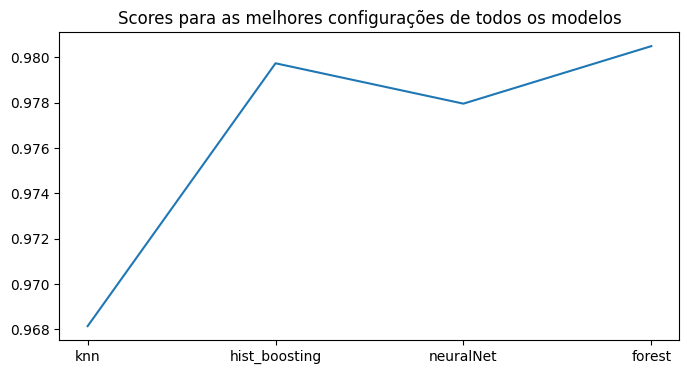

In [102]:
plt.figure(figsize=(8,4))
plt.plot(models, best_scores)
plt.title("Scores para as melhores configurações de todos os modelos")
plt.show()

In [103]:
for model, score in zip(models, best_scores):
    print(f"Score do {model}: {score}")

Score do knn: 0.968145138850242
Score do hist_boosting: 0.979742890533697
Score do neuralNet: 0.9779620457454505
Score do forest: 0.9804997495687017


De acordo com os resultados, o modelo que melhor performou foi o RandomForest. Sua melhor configuração obteve um score médio de 0.98 na validação cruzada.

A melhor configuração do RandomForest foi:

In [104]:
best_params[3]

{'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 100}

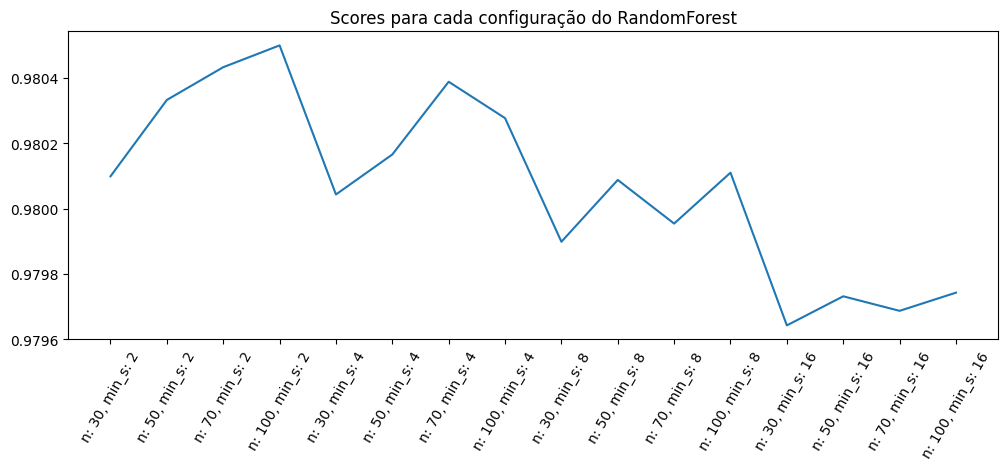

In [105]:
params_axis = [f"n: {param['n_estimators']}, min_s: {param['min_samples_split']}" for param in all_params[models[3]]]
plt.figure(figsize=(12,4))
plt.plot(params_axis, mean_test_scores[models[3]])
plt.title("Scores para cada configuração do RandomForest")
plt.xticks(rotation=60)
plt.show()

### Sobre os dados de teste

In [115]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

def plotBestEstimatorResults(estimator, X_test, y_test, model_name):
    y_pred = estimator.predict(X_test)
    print(classification_report(y_test, y_pred, digits=3))
    
    plotConfusionMatrix(y_test, y_pred, model_name)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plotROC(fpr, tpr, model_name)
    
    plotPrecisionRecall(estimator, y_test , y_pred, model_name)
    
def plotConfusionMatrix(y_test, y_pred, model=None):
    """
    https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
    """
    # cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true')
    plt.show()

def plotROC(fpr, tpr, model_name):
    """
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    """
    plt.figure(figsize=(8,6))
    lw = 2
    aucArea = auc(fpr,tpr)
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % aucArea,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.legend(loc="lower right")
    plt.show()

def plotPrecisionRecall(estimator, y_true, y_pred, modelName):
    display = PrecisionRecallDisplay.from_predictions(
        y_true, y_pred, name=modelName
    )
    _ = display.ax_.set_title("2-class Precision-Recall curve")
    plt.legend(loc='lower left')
    plt.show()

              precision    recall  f1-score   support

         0.0      0.983     0.997     0.990     28967
         1.0      0.832     0.489     0.616       982

    accuracy                          0.980     29949
   macro avg      0.907     0.743     0.803     29949
weighted avg      0.978     0.980     0.977     29949



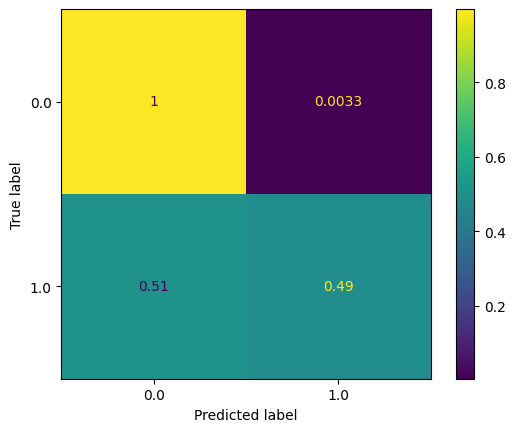

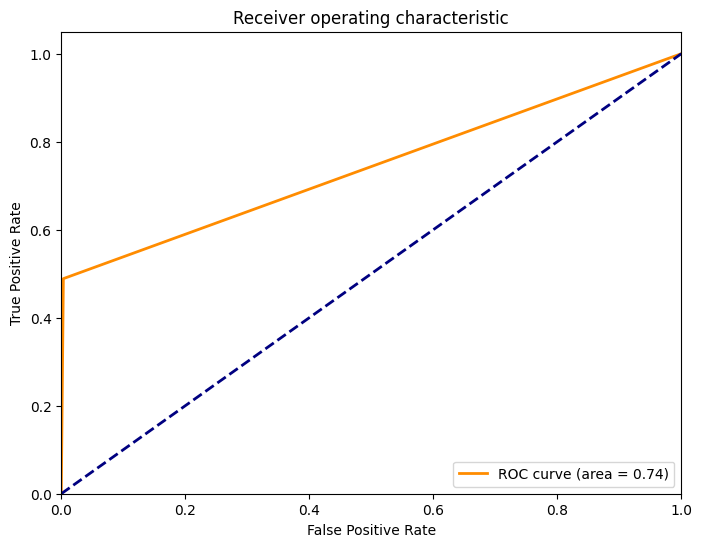

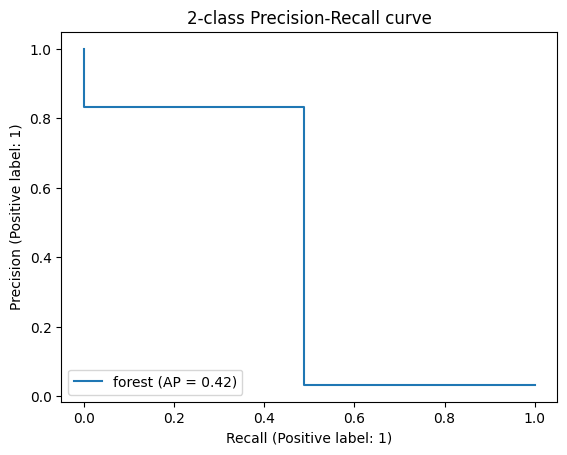

In [107]:
plotBestEstimatorResults(best_models[3], X_test, y_test, models[3])

Aconteceu o que eu temia, a grande diferença de proporção de dados died=0 e died=1 afetou o treinamento dos modelos. Ao praticamente prever sempre que a criança não morrerá, já que existem muito mais crianças que não morreram, os modelos aumentam a sua acurácia.

Vou tentar refazer os passos de treino mas com dados de treino melhor balanceados, com cerca de 60% dos dados como não morreram e 40% como morreram. Para tal, acreditarei que esses 60% que não morreram serão representativos o suficiente daqueles que não morreram para, ainda assim, manter os bons indicadores para essa classe nos resultados dos modelos.

## Retreinando com dados melhor balanceados

Vamos ver a distribuição das categorias dos dados de treino:

In [60]:
y_train.value_counts()

0.0    86833
1.0     3012
Name: died, dtype: int64

Existem 3012 instâncias onde os bebês morreram. Se isso for 40% dos dados, então isso significa que os outros 60% são 4518. Assim, vou modificar X_train para ter essa proporção e o resto irá para os dados de teste.

In [85]:
#Pegando só o que interessa para o treino

#Todos os que já eram died == 1
new_y_train = y_train[y_train == 1]
#Mais só 4518 dos que died == 0
new_y_train = pd.concat([new_y_train, y_train[y_train == 0].iloc[:4518]])

#O mesmo para o X
new_X_train = X_train[y_train == 1]
new_X_train = pd.concat([new_X_train, X_train[y_train == 0].iloc[:4518]])

#Movendo os não utilizados do treino antigo para o teste novo

#O novo y_test é o mesmo que o anterior acrescido dos died == 0 não utilizados no novo treino
new_y_test = y_test.copy()
new_y_test = pd.concat([new_y_test, y_train[y_train == 0].iloc[4518:]])

#O mesmo para o x_test
new_X_test = X_test.copy()
new_X_test = pd.concat([new_X_test, X_train[y_train == 0].iloc[4518:]])

In [79]:
new_y_train.value_counts()

0.0    4518
1.0    3012
Name: died, dtype: int64

In [80]:
new_y_test.value_counts()

0.0    111282
1.0       982
Name: died, dtype: int64

## Aplicando os mesmos modelos novamente

Mas sobre o new_X_train e new_y_train

In [108]:
JUST_LOAD_DATA = True

models = ['knn', "hist_boosting", 'neuralNet', 'forest']

best_models = []
best_scores = []
best_params = []
all_params = {}
mean_test_scores = {}
best_index = {}

import pathlib
    
target_models_dir = pathlib.Path("../models/balanced")
target_models_dir.mkdir(exist_ok=True, parents=True)

if JUST_LOAD_DATA:
    from joblib import load
    for model in models:
        grid = load(target_models_dir / f"grid_{model}.joblib")
        best_models.append(grid.best_estimator_)
        best_scores.append(grid.best_score_)
        best_params.append(grid.best_params_)
        all_params[model] = grid.cv_results_['params']
        mean_test_scores[model] = grid.cv_results_['mean_test_score']
        best_index[model] = grid.best_index_
else:
    from sklearn.model_selection import GridSearchCV
    from joblib import dump

    for i in range(len(ensemble_clf)):
        print(f"Começando treino de {ensemble_clf[i]}")
        grid=GridSearchCV(estimator=ensemble_clf[i], param_grid=parameters_list[i], 
                          n_jobs=-1, cv=5, verbose=3, scoring='accuracy').fit(new_X_train, new_y_train)
        best_models.append(grid.best_estimator_)
        best_scores.append(grid.best_score_)
        best_params.append(grid.best_params_)
        all_params[models[i]] = grid.cv_results_['params']
        mean_test_scores[models[i]] = grid.cv_results_['mean_test_score']
        best_index[models[i]] = grid.best_index_
        dump(grid.best_estimator_,target_models_dir / f"best_{models[i]}.joblib")
        dump(grid, target_models_dir / f"grid_{models[i]}.joblib")

### Nova análise dos resultados

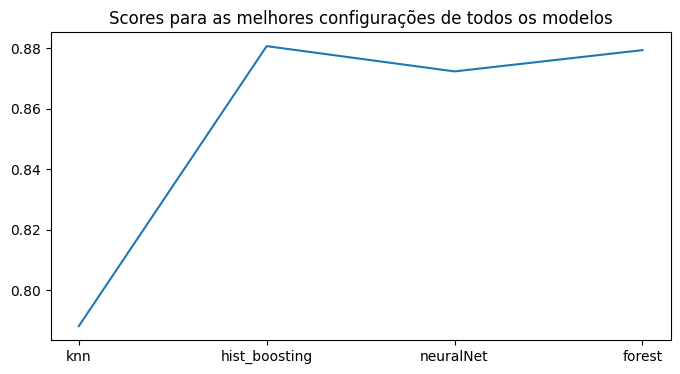

In [109]:
plt.figure(figsize=(8,4))
plt.plot(models, best_scores)
plt.title("Scores para as melhores configurações de todos os modelos")
plt.show()

In [110]:
for model, score in zip(models, best_scores):
    print(f"Score do {model}: {score}")

Score do knn: 0.7880478087649401
Score do hist_boosting: 0.8807436918990703
Score do neuralNet: 0.8723771580345285
Score do forest: 0.8794156706507303


De acordo com os resultados, o modelo que melhor performou foi o HistGradientBoosting. Sua melhor configuração obteve um score médio de 0.88 na validação cruzada.

A melhor configuração do HistGradientBoosting foi:

In [111]:
best_params[1]

{'learning_rate': 0.01, 'max_depth': 5, 'max_iter': 100}

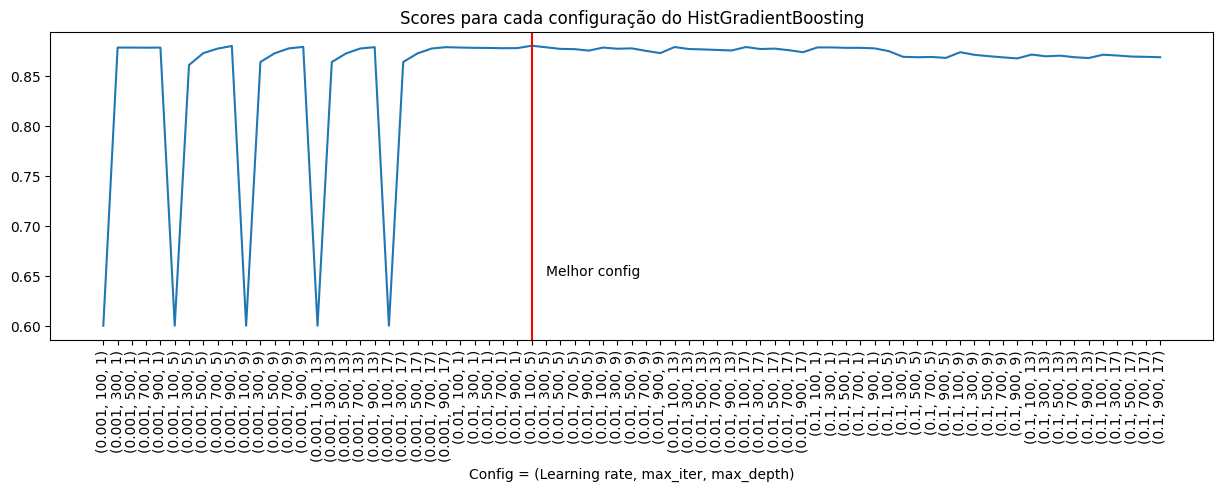

In [112]:
params_axis = [f"({param['learning_rate']}, {param['max_iter']}, {param['max_depth']})" 
                   for param in all_params[models[1]]]
plt.figure(figsize=(15,4))
plt.plot(params_axis, mean_test_scores[models[1]])
plt.xticks(rotation=90)
plt.title("Scores para cada configuração do HistGradientBoosting")

plt.axvline(30, color='red')
plt.text(31, 0.65, "Melhor config")

plt.xlabel("Config = (Learning rate, max_iter, max_depth)")
plt.show()

### Sobre os dados de teste

              precision    recall  f1-score   support

         0.0      0.998     0.946     0.971    111282
         1.0      0.111     0.763     0.194       982

    accuracy                          0.945    112264
   macro avg      0.554     0.854     0.583    112264
weighted avg      0.990     0.945     0.964    112264



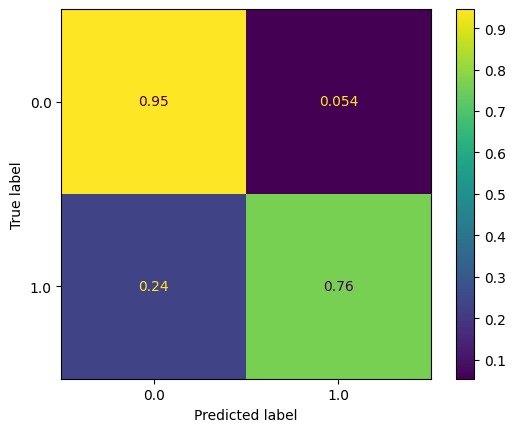

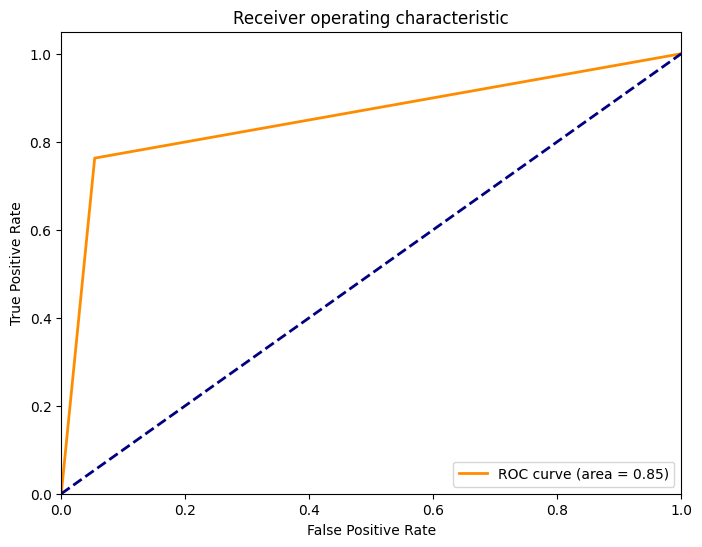

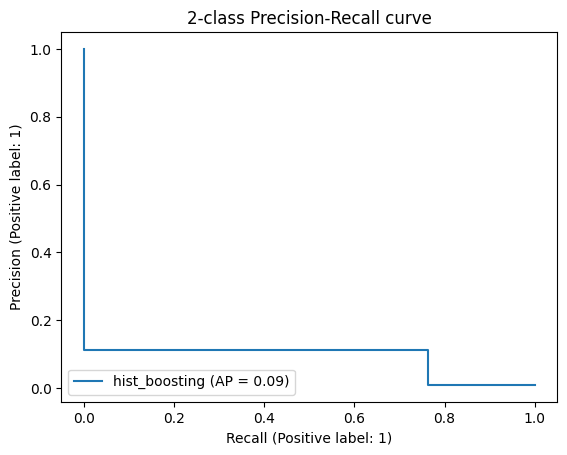

In [116]:
plotBestEstimatorResults(best_models[1], new_X_test, new_y_test, models[1])

Dessa vez, a proporção dos bebês que morreram e que foram corretamente identificados subiu para 76% sobre o custo de perder um pouco de precisão para o caso de died == 0. Dessa forma, o modelo vencedor é aquele em: ../models/balanced/best_hist_boosting.joblib